# Notebook \#2 - Implementation of Fourier Neural Operator

In [6]:
from data import MultiFunctionDatasetODE, custom_collate_ODE_fn_fno 
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from model_fno import *
from scripts import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -------------------------
# Hyperparameters and Setup
# -------------------------
n_functions = 1000000
end_time = 1.0
m = 200
batch_size = 1024

# Time grid
t_grid = torch.linspace(0, end_time, m).unsqueeze(0).repeat(batch_size, 1).unsqueeze(-1)

# Dataset and Dataloader
dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial', 'constant'],
    end_time=end_time,
    num_domain=m,
    num_initial=20,
    grf_lb=0.02,
    grf_ub=0.5
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn_fno, shuffle=True)

In [ ]:
step_size = 100
gamma = 0.9
learning_rate = 0.001

model = FNO1d(modes=16, width=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

epochs = 100
trained_model = train_fno(model, dataloader, optimizer, scheduler, epochs, t_grid)

In [2]:
# Model setup
trained_model = FNO1d(modes=16, width=64)
trained_model.to(device)
trained_model.load_state_dict(torch.load('trained_models/fno/width-[64]-modes[16]/model_epoch10_20250421-212647_loss0.0013.pth'))
trained_model.eval()  #

FNO1d(
  (conv1): SimpleBlock1d(
    (fc0): Linear(in_features=2, out_features=64, bias=True)
    (conv0): SpectralConv1d()
    (conv1): SpectralConv1d()
    (conv2): SpectralConv1d()
    (conv3): SpectralConv1d()
    (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [4]:
m = 200 
end_time = 1
epochs = 1500
learning_rate = 0.001

u_opt, x_opt, t_opt = optimize_neural_operator(trained_model, objective_function, m, end_time, epochs, learning_rate, model_name="fno")

Epoch [100/1500], Loss: 0.4417, time: 20:36:35.194045
Epoch [200/1500], Loss: 0.4157, time: 20:36:35.576141
Epoch [300/1500], Loss: 0.4011, time: 20:36:35.952759
Epoch [400/1500], Loss: 0.3930, time: 20:36:36.326915
Epoch [500/1500], Loss: 0.3886, time: 20:36:36.702559
Epoch [600/1500], Loss: 0.3864, time: 20:36:37.077212
Epoch [700/1500], Loss: 0.3852, time: 20:36:37.451185
Epoch [800/1500], Loss: 0.3846, time: 20:36:37.827211
Epoch [900/1500], Loss: 0.3843, time: 20:36:38.201641
Epoch [1000/1500], Loss: 0.3841, time: 20:36:38.575692
Epoch [1100/1500], Loss: 0.3841, time: 20:36:38.950181
Epoch [1200/1500], Loss: 0.3840, time: 20:36:39.325073
Epoch [1300/1500], Loss: 0.3840, time: 20:36:39.700554
Epoch [1400/1500], Loss: 0.3840, time: 20:36:40.075585
Epoch [1500/1500], Loss: 0.3840, time: 20:36:40.449922


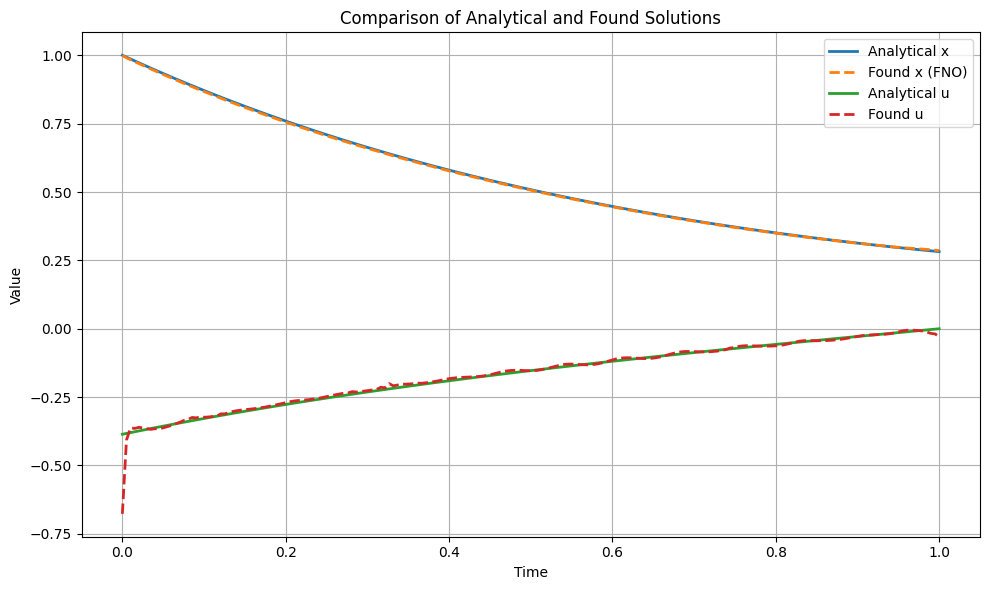

In [11]:
# Define analytical solutions using NumPy (if not defined yet)
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Create a time grid for plotting. Here t_plot is a NumPy array of shape (m,)
t_plot = np.linspace(0, end_time, m)

# Compute analytical solutions.
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

x_found = x_opt.cpu().detach().numpy().flatten()
u_found = u_opt.cpu().detach().numpy().flatten()
u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device)  # shape [1, 200]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x", linewidth=2)
plt.plot(t_plot, x_found, label="Found x (FNO)", linestyle='--', linewidth=2)
plt.plot(t_plot, analytical_u_vals, label="Analytical u", linewidth=2)
plt.plot(t_plot, u_found, label="Found u", linestyle='--', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Comparison of Analytical and Found Solutions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()